In [2]:
pip install dahuffman

Note: you may need to restart the kernel to use updated packages.


In [51]:
"""
Image Processing Laboratory (45108) - Meeting 3
Signal and Image Processing Lab (SIPL) & Vision and Image Sciences Lab (VISL)
The Andrew and Enra Viterbi Faculty of Electrical and Computer Engineering
Technion - Israel Institute of Technology
"""

from collections import namedtuple, Counter
import numpy as np
from scipy import fft
from scipy.io import loadmat
from skimage import color, io, measure, metrics, transform, util
from dahuffman import HuffmanCodec
import matplotlib.pyplot as plt

from code.block_process import block_process
from code.zigzag import zigzag, izigzag
from code.im_preparation import visual_prep, thermal_prep_uint8

# Preparation - Assignment 1 - Getting to Know the block_process Function


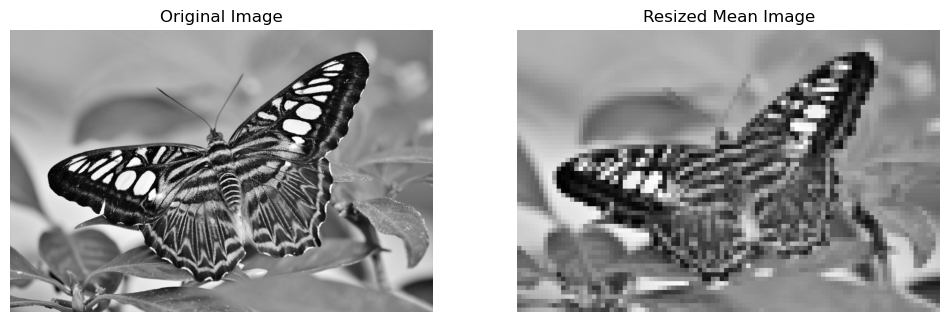

In [25]:
# Load input image
prep_image = io.imread('images/9/prep.png', as_gray=True)

# Create a function handle to a function for mean calculation
function_handle = np.mean

# TODO: Use the 'block_process' function to get the mean image of every 8x8 block
block_size = [8,8]
mean_image = block_process(prep_image, block_size, function_handle)

# Resize the mean image to the size of the original image using nearest neighbor interpolation
resized_mean_image = transform.resize(mean_image, (prep_image.shape[0], prep_image.shape[1]), order=0)

# Show the original and the resized mean image
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(prep_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(resized_mean_image, cmap='gray')
plt.title('Resized Mean Image')
plt.axis('off')
plt.show()


# Preparation - Assignment 3 - Differential Coding


In [27]:
# Question 1

def diff_coding(data, distance=1):
    """
    Calculates the differential code of a data matrix or vector.

    Args:
        data (np.ndarray): The input data matrix or vector.
        distance(int, default: 1): The distance between elements to subtract.

    Returns:
        np.ndarray with the differential code matrix or vector.
    """

    # If distance is 0, return input data unchanged
    if distance == 0:
        return np.copy(data)

    # Convert to a signed datatype to allow negative difference values
    data_int16 = data.astype(np.int16)

    code = np.zeros_like(data_int16)
    # Copy first distance elements
    code[:distance] = data_int16[:distance]

    # TODO: Calculate the differential code for the remaining elements
    
    for i in range(distance, data_int16.shape[0]):   ## fill in the first collumn
        code[i,0] = data_int16[i,0] - data_int16[i-distance,0]

    for i in (range(1, data_int16.shape[1])):   ## fill in the rest
        for j in (range(data_int16.shape[0])):
            code[j,i] = data_int16[j,i] - data_int16[j-distance,i]

    return code


def diff_decoding(code, distance):
    """
    Reconstructs the original data matrix or vector from differential code.

    Args:
        code (np.ndarray): The Differential code matrix or vector.
        distance (int): Distance between elements subtracted.

    Returns:
        np.ndarray with the The reconstructed data matrix or vector.
    """

    # If distance is 0, return input data unchanged
    if distance == 0:
        return np.copy(code)

    rows_num = code.shape[0]

    data = np.copy(code)

    # Copy first distance elements
    data[:distance] = code[:distance]

    # TODO: Recostruct the remaining elements
    
    for i in range(distance, code.shape[0]):   ## fill in the first collumn
        data[i,0] = code[i,0] + code[i-distance,0]

    for i in (range(1, code.shape[1])):   ## fill in the rest
        for j in (range(code.shape[0])):
            data[j,i] = code[j,i] - code[j-distance,i]

    
    
    return data


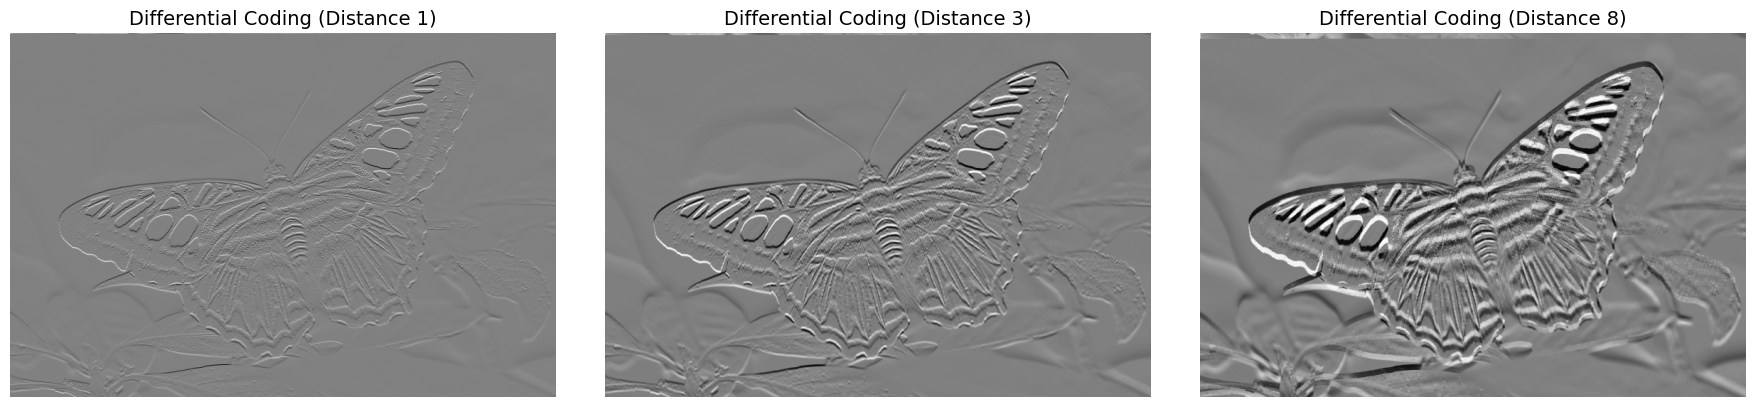

In [31]:
# Question 2

prep_image = util.img_as_ubyte(prep_image)

# TODO: Perform differential coding for prep_image with distances 1, 3, and 8.
prep_diff_coding_1 = diff_coding(prep_image, distance=1)
prep_diff_coding_3 = diff_coding(prep_image, distance=3)
prep_diff_coding_8 = diff_coding(prep_image, distance=8)

# Show the results
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.imshow(prep_diff_coding_1, cmap='gray')
plt.title('Differential Coding (Distance 1)', fontsize=14)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(prep_diff_coding_3, cmap='gray')
plt.title('Differential Coding (Distance 3)', fontsize=14)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prep_diff_coding_8, cmap='gray')
plt.title('Differential Coding (Distance 8)', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()


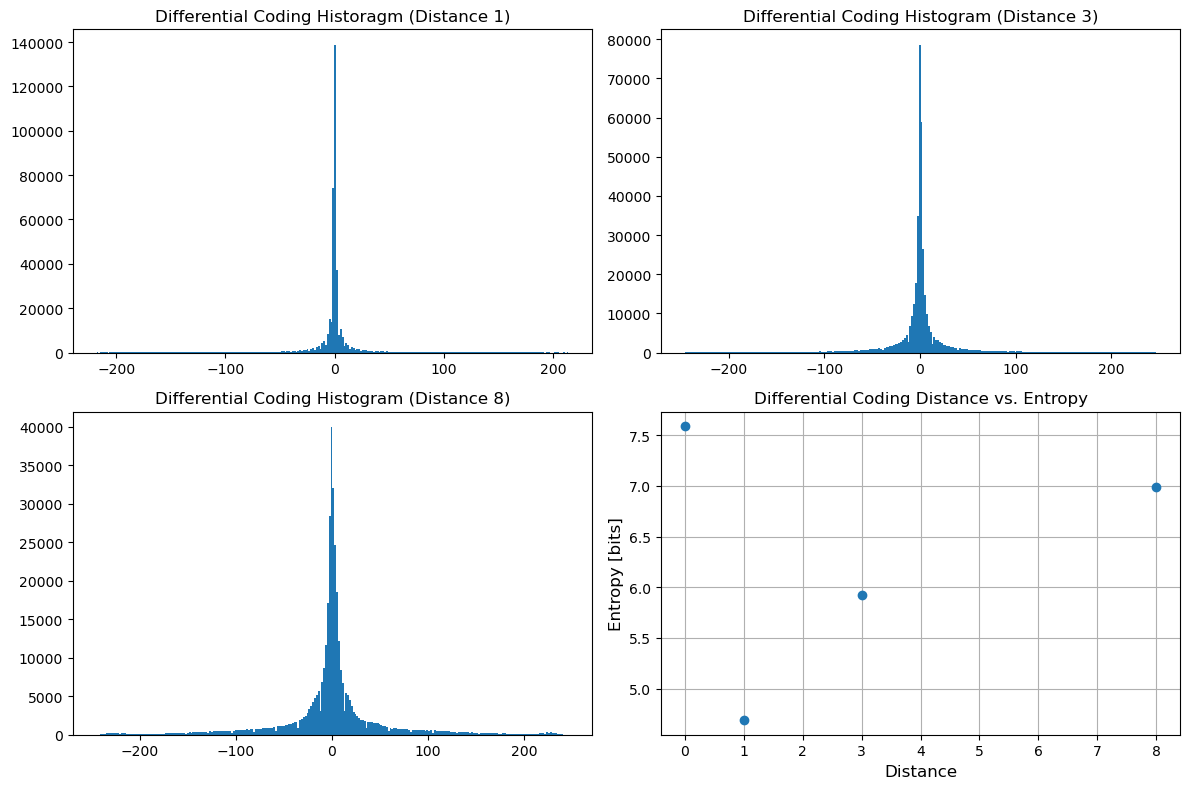

In [32]:
# Question 3

# TODO: Show differential coding histograms
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.hist(prep_diff_coding_1.flatten() ,256)
plt.title('Differential Coding Historagm (Distance 1)', fontsize=12)

plt.subplot(2, 2, 2)
plt.hist(prep_diff_coding_3.flatten() ,256)
plt.title('Differential Coding Histogram (Distance 3)', fontsize=12)

plt.subplot(2, 2, 3)
plt.hist(prep_diff_coding_8.flatten() ,256)
plt.title('Differential Coding Histogram (Distance 8)', fontsize=12)


distances = [0, 1, 3, 8]
# TODO: Calculate entropy using the 'measure.shannon_entropy' function
entropy = np.zeros(4)
entropy[0] = measure.shannon_entropy(diff_coding(prep_image,0))
entropy[1] = measure.shannon_entropy(prep_diff_coding_1)
entropy[2] = measure.shannon_entropy(prep_diff_coding_3)
entropy[3] = measure.shannon_entropy(prep_diff_coding_8)

# Show entropy
plt.subplot(2, 2, 4)
plt.plot(distances, entropy, marker='o', linestyle='None')
plt.title('Differential Coding Distance vs. Entropy', fontsize=12)
plt.xlabel('Distance', fontsize=12)
plt.ylabel('Entropy [bits]', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


# Preparation - Assignment 4 - Quantization


In [35]:
# Question 1

def im_quantize(image, levels_num):
    """
    Quantizes an image to a specified number of intensity levels.

    This function takes a grayscale image as input and reduces the number of
    unique intensity values to the specified number of levels. It achieves
    this by dividing the original intensity range into equal-sized buckets
    and assigning each pixel's intensity to the midpoint of the bucket it falls into.

    Args:
      image (np.ndarray): The input grayscale image.
      levels_num (int, a power of 2): The desired number of quantization levels.

    Returns:
      A tuple containing the quantized image (np.ndarray) and the
      compression ratio achieved by quantization (float).
    """

    quantized_image = np.copy(image)

    # TODO: Get minimum and maximum intensity values
    min_intensity  = np.min(quantized_image)
    max_intensity  = np.max(quantized_image)

    # TODO: Create an array of evenly spaced intensity bin edges
    bin_edges = np.linspace(min_intensity,max_intensity,levels_num)

    # TODO: Quantize the image
    for i in range(len(bin_edges) - 1):
        quantized_image[(image >= bin_edges[i]) & (image <= bin_edges[i + 1])] = (bin_edges[i + 1] + bin_edges[i])/2

    # Calculate the compression ratio
    compression_ratio  = np.log2(max_intensity  - min_intensity  + 1) / np.log2(levels_num)

    return quantized_image, compression_ratio


In [ ]:
# Question 2

# TODO: Quantize prep_image to 128, 16 and 4 levels
prep_quantized_128levels, compression_ratio_128levels = im_quantize(prep_image,128)
prep_quantized_16levels, compression_ratio_16levels = im_quantize(prep_image,16)
prep_quantized_4levels, compression_ratio_4levels = im_quantize(prep_image,4)

# TODO: Compute PSNR & SSIM using the 'metrics.peak_signal_noise_ratio' & 'metrics.structural_similarity' functions
psnr_128levels = metrics.peak_signal_noise_ratio(prep_image,prep_quantized_128levels)
psnr_16levels = metrics.peak_signal_noise_ratio(prep_image,prep_quantized_16levels)
psnr_4levels = metrics.peak_signal_noise_ratio(prep_image,prep_quantized_4levels)
ssim_128levels = metrics.structural_similarity(prep_image,prep_quantized_128levels)
ssim_16levels = metrics.structural_similarity(prep_image,prep_quantized_16levels)
ssim_4levels = metrics.structural_similarity(prep_image,prep_quantized_4levels)

# Show quantized images
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.imshow(prep_quantized_128levels, cmap='gray')
plt.title('Quantization: 128 levels', fontsize=14)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(prep_quantized_16levels, cmap='gray')
plt.title('Quantization: 16 levels', fontsize=14)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prep_quantized_4levels, cmap='gray')
plt.title('Quantization: 4 levels', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()

# Print compression ratios
print(f"Compression ratios for 128, 16, 4 levels: {compression_ratio_128levels:.2f}, {compression_ratio_16levels:.2f}, {compression_ratio_4levels:.2f}")

# Print PSNR & SSIM values
print(f"PSNR [dB] for 128, 16, 4 levels: {round(psnr_128levels,2)}, {round(psnr_16levels,2)}, {round(psnr_4levels,2)}")
print(f"SSIM for 128, 16, 4 levels: {round(ssim_128levels,2)}, {round(ssim_16levels,2)}, {round(ssim_4levels,2)}")


# Preparation - Assignment 5 - DCT


In [78]:
def crop(image, block_size, corner):
    """
    Crops a block of given size from the image starting at the specificed corner.

  Args:
      image (np.ndarray): The image to crop.
      block_size (int): The size of the block to crop.
      corner (tuple of ints): (y,x) coordinates of the top-left corner of the block to crop.

  Returns:
      np.ndarray of the cropped block.
  """

    block =  image[corner.y-1:(corner.y-1 + block_size), corner.x-1:(corner.x-1 + block_size)]

    return block


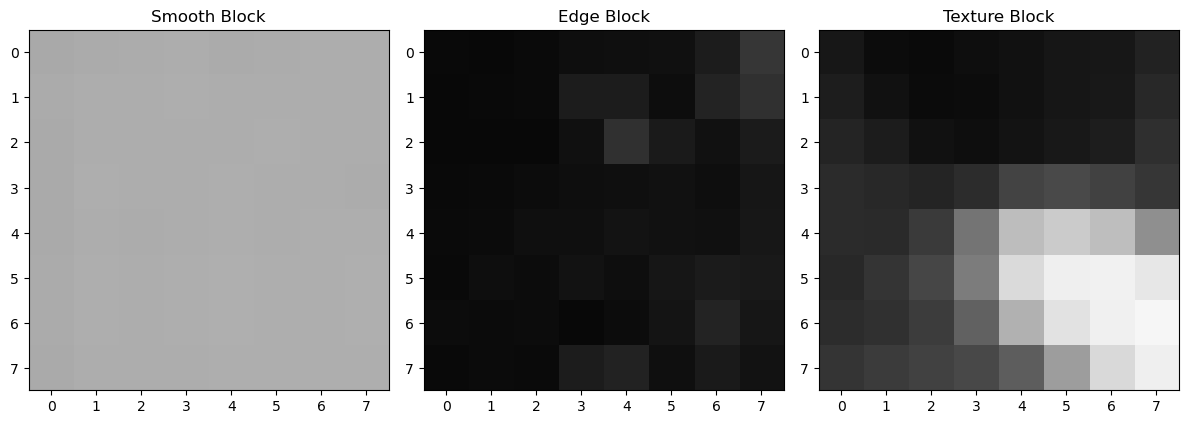

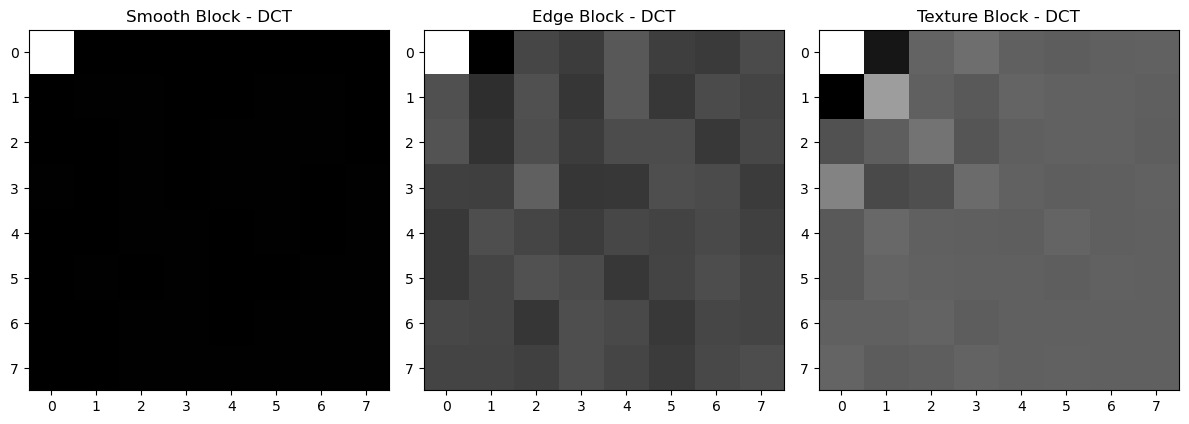

In [68]:
# Question 1

# Define block size and corner coordinates
block_corner = namedtuple('corner', ['x','y'])
block_size = 8

# TODO: Choose three blocks from prep_image
smooth_block_corner = [0,0]
edge_block_corner = [311,137]
texture_block_corner = [390,250]

# TODO: Extract blocks from the image
smooth_block = prep_image[smooth_block_corner[0]:(smooth_block_corner[0]+8), smooth_block_corner[1]:(smooth_block_corner[1]+8)]
edge_block = prep_image[edge_block_corner[0]:(edge_block_corner[0]+8), edge_block_corner[1]:(edge_block_corner[1]+8)]
texture_block = prep_image[texture_block_corner[0]:(texture_block_corner[0]+8), texture_block_corner[1]:(texture_block_corner[1]+8)]

# Show blocks
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(smooth_block, cmap='gray', vmin=0, vmax=255)
plt.title('Smooth Block')
plt.subplot(1, 3, 2)
plt.imshow(edge_block, cmap='gray', vmin=0, vmax=255)
plt.title('Edge Block')
plt.subplot(1, 3, 3)
plt.imshow(texture_block, cmap='gray', vmin=0, vmax=255)
plt.title('Texture Block')
plt.tight_layout()
plt.show()

# Perform DCT on the three blocks
smooth_block_dct = fft.dctn(smooth_block, norm='ortho')
edge_block_dct = fft.dctn(edge_block, norm='ortho')
texture_block_dct = fft.dctn(texture_block, norm='ortho')

# Show DCT coefficients
plt.figure(figsize=(12, 4))

plt.subplot(1,3,1)
plt.imshow(smooth_block_dct, cmap='gray')
plt.title('Smooth Block - DCT')
plt.subplot(1,3,2)
plt.imshow(edge_block_dct, cmap='gray')
plt.title('Edge Block - DCT')
plt.subplot(1,3,3)
plt.imshow(texture_block_dct, cmap='gray')
plt.title('Texture Block - DCT')
plt.tight_layout()
plt.show()

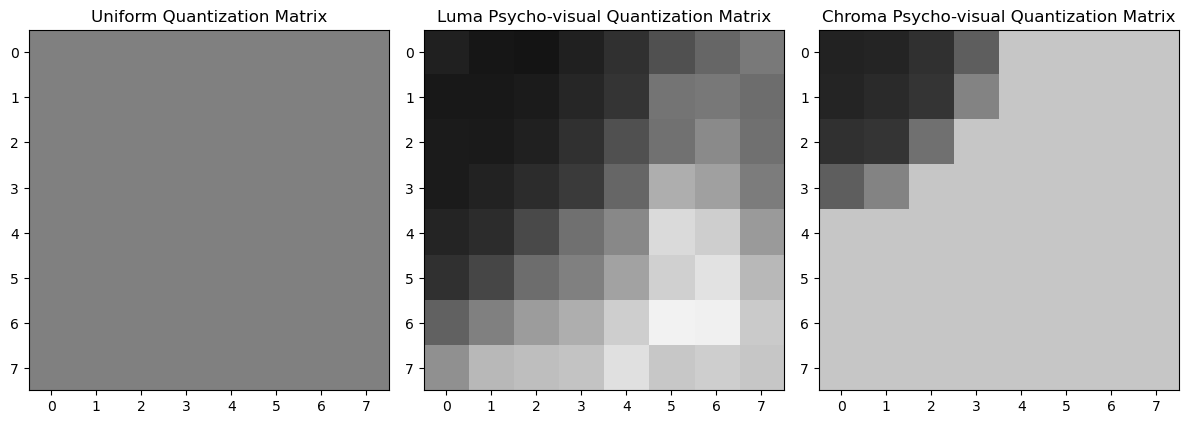

In [71]:
# Question 2

# Display quantization matrices
qmatrices = loadmat("code/quantization_matrices.mat")

uniform_qmatrix = qmatrices["uniform"]
psyvisual_qmatrix = qmatrices["psyvisual"]
chroma_qmatrix = qmatrices["chroma"]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(uniform_qmatrix, cmap="gray", vmin=0, vmax=32)
plt.title('Uniform Quantization Matrix')

plt.subplot(1,3,2)
plt.imshow(psyvisual_qmatrix, cmap="gray", vmin=0, vmax=128)
plt.title('Luma Psycho-visual Quantization Matrix')

plt.subplot(1,3,3)
plt.imshow(chroma_qmatrix, cmap="gray", vmin=0, vmax=128)
plt.title('Chroma Psycho-visual Quantization Matrix')

plt.tight_layout()
plt.show()


In [101]:
# Question 3

# Run Block-DCT viewer app
!python code/dct_viewer_app.ipynb


Traceback (most recent call last):
  File "C:\Users\orihe\Documents\sem 6\imglab\meeting3\code\dct_viewer_app.ipynb", line 132, in <module>
    "execution_count": null,
                       ^^^^
NameError: name 'null' is not defined


In [34]:

# Question 4

def dct_quantize(image_block, qmatrix, qf):
    """
    Performs DCT (Discrete Cosine Transform) and quantization on an image block.

    Args:
      patch (np.ndarray): The image block.
      qmatrix (np.ndarray): The quantization matrix.
      qf (float): The quality factor for scaling.

    Returns:
      np.ndarray of the DCT transformed and quantized image block.
    """

    # TODO: Perform DCT on the image block using the 'fft.dctn' function
    #       with parameter 'norm='ortho''
    dct_block = fft.dctn(image_block, norm = 'ortho')

    # TODO: Perform quantization using qmatrix and scaling using qf
    #       You can use the np.divide function
    quantized_block = np.divide(dct_block, qmatrix*qf)

    return np.floor(quantized_block + 0.5).astype(int)


def dequantize_idct(coded_block, qmatrix, qf):
    """
    Performs dequantization and inverse DCT (Discrete Cosine Transform) on a coded block.

    Args:
      coded_block (np.ndarray): The coded image block.
      qmatrix (np.ndarray): The quantization matrix.
      qf (float): The quality factor for scaling.

    Returns:
      np.ndarray of the reconstructed image block.
    """

    # TODO: Perform inverse scaling using qf and dequantization using qmatrix
    dequantized_block =  dequantized_block = np.multiply(coded_block, qmatrix*qf)

    # TODO: Perform inverse DCT on the dequantized image block using the 'fft.idctn' function
    #       with parameter 'norm='ortho''
    reconstructed_block  = fft.idctn(dequantized_block, norm = 'ortho')

    return np.floor(reconstructed_block + 0.5).astype(int)

# Preparation - Assignment 6 - Color Image Coding


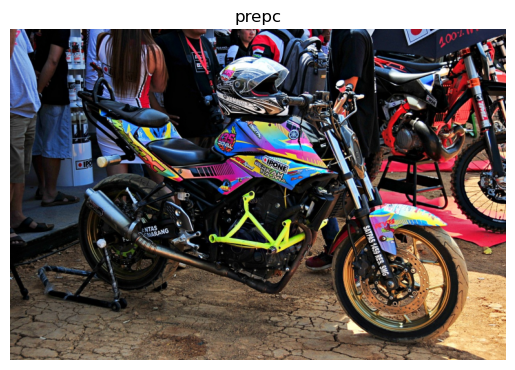

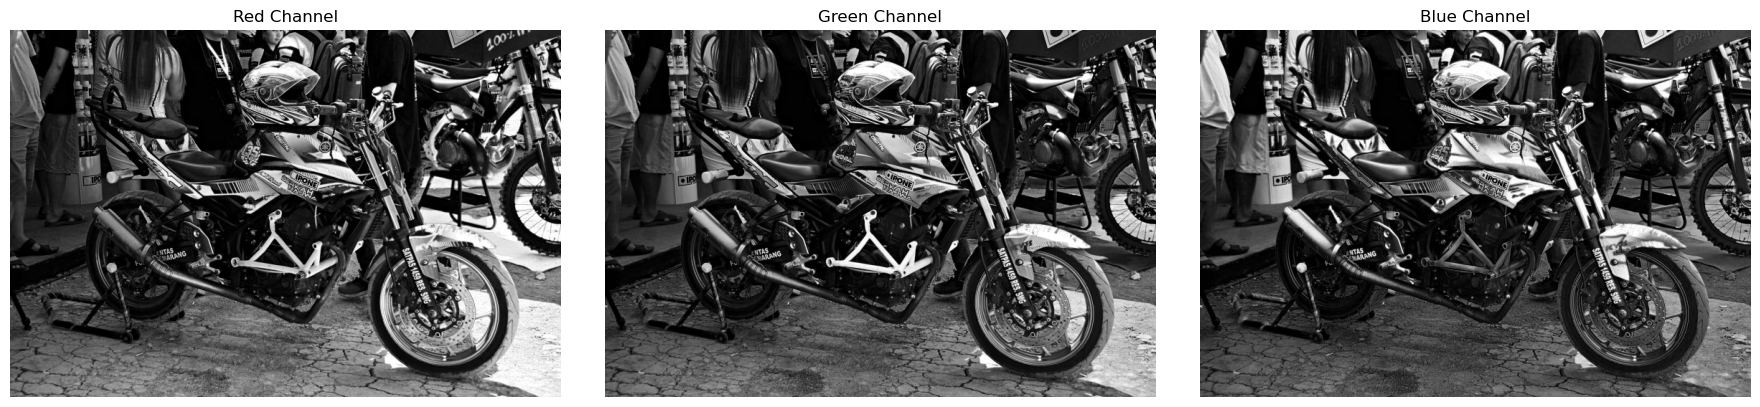

Covariance between RGB channels:
[[4701.72   74.06  129.31]
 [  74.06 4893.02  -78.5 ]
 [ 129.31  -78.5  3058.27]]


In [113]:
# Question 1

# Load and show the image
prepc_image = io.imread('images/9/prepc.png')

plt.imshow(prepc_image)
plt.title('prepc')
plt.axis('off')
plt.show()

# TODO: Extract RGB channels
red_channel = prepc_image[:,:,0]
green_channel = prepc_image[:,:,1]
blue_channel = prepc_image[:,:,2]


# Show RGB channels
plt.figure(figsize=(18,4))

plt.subplot(1,3,1)
plt.imshow(red_channel, cmap="gray")
plt.title('Red Channel')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(green_channel, cmap="gray")
plt.title('Green Channel')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(blue_channel, cmap="gray")
plt.title('Blue Channel')
plt.axis('off')

plt.tight_layout()
plt.show()

# TODO: Create a matrix that contains the RGB channels as its rows
#       using the 'np.reshape' function
rgb_matrix =  np.reshape(prepc_image, (3,red_channel.size))


# Compute and print the covariance between the RGB channels
print("Covariance between RGB channels:")
rgb_covariance = np.cov(rgb_matrix)
print(np.round(rgb_covariance, decimals=2))


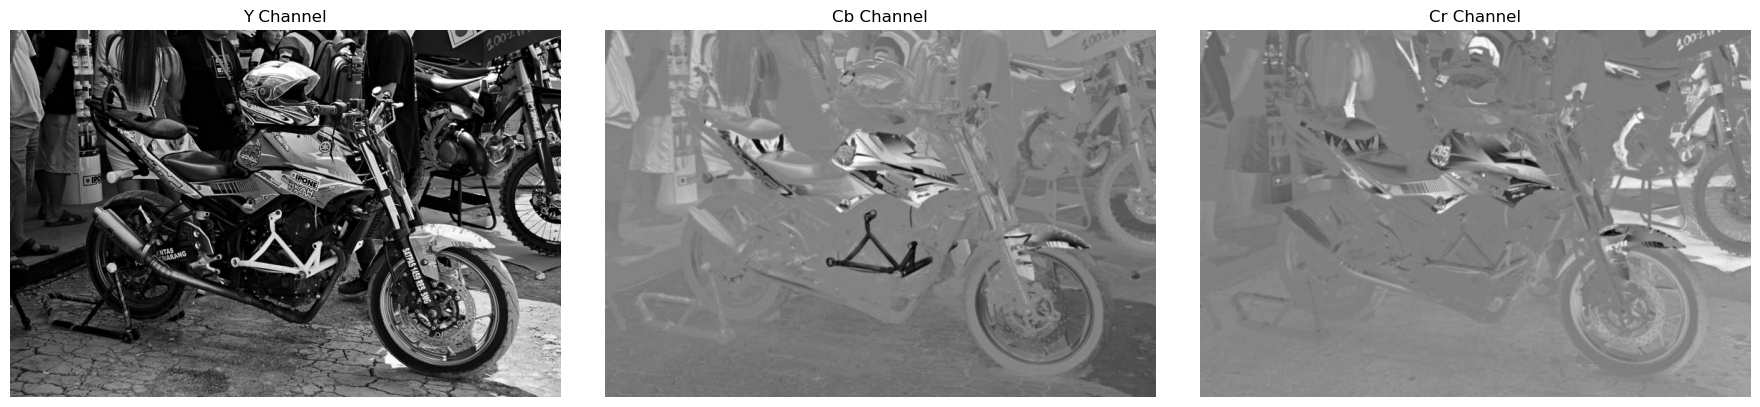

Covariance between YCbCr channels:
[[2032.63  813.49  542.8 ]
 [ 813.49 2037.85  456.41]
 [ 542.8   456.41 1141.68]]


In [121]:
# Question 2

# Convert the RGB image to YCbCr
prepc_ycbcr = color.rgb2ycbcr(prepc_image)

# TODO: Extract YCbCr channels
y_channel =prepc_ycbcr[:,:,0]
cb_channel = prepc_ycbcr[:,:,1]
cr_channel = prepc_ycbcr[:,:,2]

# Show YCbCr channels
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.imshow(y_channel, cmap="gray")
plt.title('Y Channel')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(cb_channel, cmap="gray")
plt.title('Cb Channel')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(cr_channel, cmap="gray")
plt.title('Cr Channel')
plt.axis('off')

plt.tight_layout()
plt.show()

# TODO: Create a matrix that contains the YCbCr channels as its rows
#       using the 'np.reshape' function
ycbcr_matrix=np.reshape(prepc_ycbcr, (3,y_channel.size))

# Compute and print the covariance between the YCbCr channels
print("Covariance between YCbCr channels:")
ycbcr_covariance = np.cov(ycbcr_matrix)
print(np.round(ycbcr_covariance, decimals=2))


# Assignment 1 - Introduction


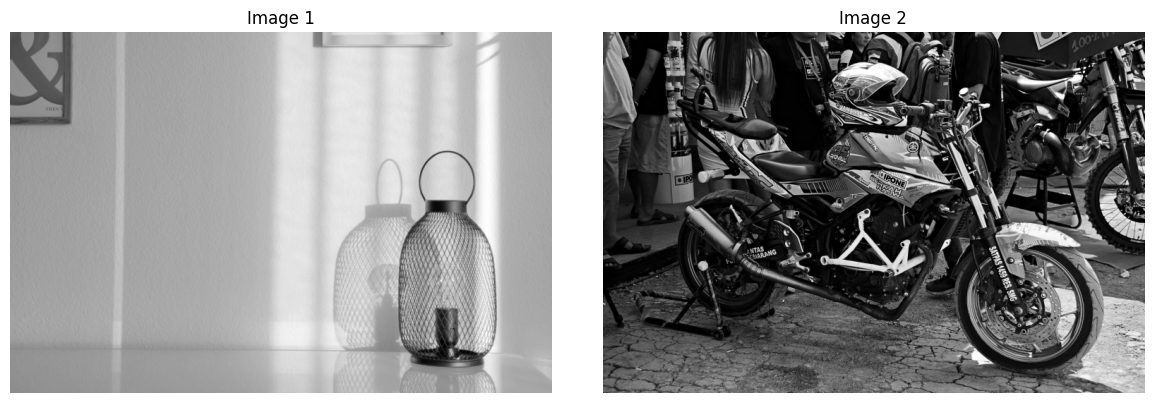

In [4]:
# Question 1

# TODO: Load the images as grayscale
exp_image1 = io.imread('images/0/exp1.png', as_gray=True)
exp_image2 = io.imread('images/0/exp2.png', as_gray=True)

exp_image1 = (exp_image1 * 255).astype(np.uint8)
exp_image2 = (exp_image2 * 255).astype(np.uint8)

# Show the images
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(exp_image1, cmap="gray")
plt.title("Image 1")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(exp_image2, cmap="gray")
plt.title("Image 2")
plt.axis('off')

plt.tight_layout()
plt.show()


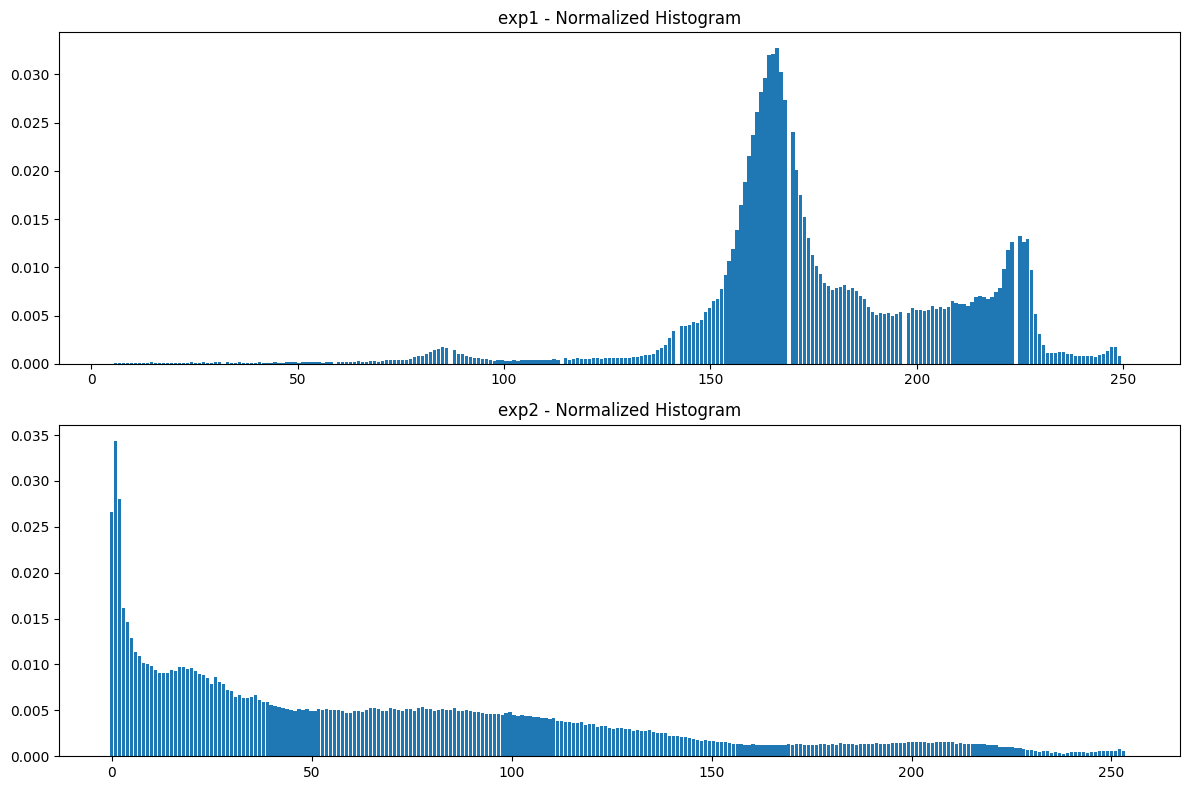

In [5]:
# Question 2

# Calculate and show normalized image histograms
plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
hist_counts1, bin_edges1 = np.histogram(exp_image1.flatten(), bins=256, density=True)
hist_counts1 /= np.sum(hist_counts1)
plt.bar(bin_edges1[:-1], hist_counts1)
plt.title("exp1 - Normalized Histogram")

plt.subplot(2,1,2)
hist_counts2, bin_edges2 = np.histogram(exp_image2.flatten(), bins=256, density=True)
hist_counts2 /= np.sum(hist_counts2)
plt.bar(bin_edges2[:-1], hist_counts2)
plt.title("exp2 - Normalized Histogram")

plt.tight_layout()
plt.show()


In [6]:
# Question 3

# TODO: Calculate image entropies using the 'measure.shannon_entropy' function
entropy1 = measure.shannon_entropy(exp_image1)
entropy2 = measure.shannon_entropy(exp_image2)

print(f"exp1 entropy: {round(entropy1, 2)}")
print(f"exp2 entropy: {round(entropy2, 2)}")


exp1 entropy: 6.62
exp2 entropy: 7.46


In [13]:
# Question 4

# TODO: Calculate uncompressed image sizes in bits
image1_uncompressed_size = 8*exp_image1.size
image2_uncompressed_size = 8*exp_image2.size

# Print uncompressed image sizes
print(f"exp1 uncompressed size [bits]: {image1_uncompressed_size}")
print(f"exp2 uncompressed size [bits]: {image2_uncompressed_size}")


exp1 uncompressed size [bits]: 3145728
exp2 uncompressed size [bits]: 3145728


# Assignment 2 - Entropy Coding


In [9]:
# Question 1

def huffman_encode(data):
    """
    Performs Huffman coding on the input data.

    Args:
        data (1D np.ndarray): The input data to be encoded.

    Returns:
        A tuple containing the encoded data and the codebook.
            1D np.ndarray of the encoded data.
            dict of a codebook mapping pixel values to their Huffman codes.
    """

    # Create Huffman coder from symbol frequencies
    pixel_freqs = Counter(data)
    coder = HuffmanCodec.from_frequencies(
        {pixel_val: count for pixel_val, count in pixel_freqs.items()})

    # TODO: Encode the data and get the codebook using coder's
    #       'encode' and 'get_code_table' functions
    code = coder.encode(data)
    codebook = coder.get_code_table()

    return code, codebook


def huffman_decode(code, codebook):
    """
    Performs Huffman decoding on the input code using the provided codebook.

    Args:
        code (1D np.ndarray): The encoded data to be decoded.
        codebook (dict): The codebook used for encoding.

    Returns:
        1D np.ndarray of the decoded data.
    """
    # Create a Huffman coder from the codebook
    coder = HuffmanCodec(code_table=codebook)

    # Decode the code using the coder
    data = coder.decode(code)

    try:
        eof_index = data.index(np.pi)
    except ValueError:
        eof_index = len(data)+1

    data = data[:eof_index]

    return np.array(data)


In [11]:
# Question 2

# TODO: Perfom Huffman coding and decoding on exp_image1 or exp_image2
#       Don't forget to 'flatten' the image before encoding and to
#       'reshape' back after decoding
encode1 , codebook = huffman_encode(exp_image1.flatten())
decode1 = huffman_decode(encode1 ,codebook)
decode1 = decode1.reshape(exp_image1.shape)
# TODO: Compare the original and the reconstructed image using PSNR and SSIM
huffman_psnr = metrics.peak_signal_noise_ratio(exp_image1, decode1)
huffman_ssim = metrics.structural_similarity(exp_image1, decode1)

print("Huffman coding results:")
print(f"PSNR: {huffman_psnr:.2f}")
print(f"SSIM: {huffman_ssim:.2f}")


C:\Users\danelv\.conda\envs\ip_lab\Lib\site-packages\skimage\metrics\simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)


Huffman coding results:
PSNR: inf
SSIM: 1.00


In [16]:
# Question 3

def compression_ratio(image, code, codebook, include_codebook=True):
    """
    Computes the compression ratio of an image.

    Args:
        image (np.ndarray): The original uncompressed image.
        code (np.ndarray): The encoded image as a string of bits.
        codebook (dict): The codebook used for encoding. Required if include_codebook is True.
        include_codebook (bool, deafult=True): Whether to include the codebook size in the calculation.

    Returns:
        A float of the compression ratio of the image.
    """

    # TODO: Calculate the image size in bits
    image_size = 8*image.size

    # TODO: Calculate the code size in bits
    code_size = 8*len(code)

    if include_codebook:
        # Calculate the the codebook size in bits
        codebook_keys_size = sum(8 for _ in codebook)
        codebook_values_size = sum(len(c) for c in codebook.values())
        codebook_size = codebook_keys_size + codebook_values_size
        encoded_size = code_size + codebook_size
    else:
        encoded_size = code_size

    return image_size / encoded_size


# TODO: Perform Huffman encoding on one of the images
code, codebook = huffman_encode(exp_image1.flatten())

# TODO: Calculate the code size in bits
code_size = 8*len(code)
print(f"Image code size [bits]: {code_size}")

# TODO: Calculate the compression ratio without the codebook size
comp_ratio = compression_ratio(exp_image1, code, codebook ,include_codebook =False) 
print(f"Image compression ratio without codebook size: {comp_ratio:.2f}")


Image code size [bits]: 2614200
Image compression ratio without codebook size: 1.20


In [23]:
# Question 4

# Calculate the codebook size in bits
codebook_keys_size = sum(8 for _ in codebook)
codebook_values_size = sum(len(code) for code in codebook.values())
codebook_size = codebook_keys_size + codebook_values_size
print(f"Codebook size [bits]: {codebook_size}")

# TODO: Calculate the compression ratio with the codebook size

comp_ratio = compression_ratio(exp_image1, code, codebook ,include_codebook =True)
print(f"Image compression ratio with codebook size: {comp_ratio:.2f}")


Codebook size [bits]: 2490
Image compression ratio with codebook size: 1.20


In [26]:
# Question 5

filenames = ['images/entropy/entropy1.png', 'images//entropy/entropy2.png', 'images//entropy/entropy3.png', 'images//entropy/entropy4.png']

# TODO: Perform Huffman encoding on the four images (as grayscale uint8)
#       and print the compression ratios

for filename in filenames:
    entropy = io.imread(filename, as_gray=True) 
    entropy = (entropy * 255).astype(np.uint8)
    flattened_entropy = entropy.flatten()
    encoded_data, entropy_codebook = huffman_encode(flattened_entropy)  
    # Calculate compression ratio
    comp_ratio = compression_ratio(entropy, encoded_data, entropy_codebook)
        
    # Print compression ratio for current image
    print(f"Compression ratio for {filename}: {comp_ratio:.5f}")

Compression ratio for images/entropy/entropy1.png: 1.01583
Compression ratio for images//entropy/entropy2.png: 1.73160
Compression ratio for images//entropy/entropy3.png: 1.38031
Compression ratio for images//entropy/entropy4.png: 1.24957


# Assignment 3 - Grayscale Image Compression


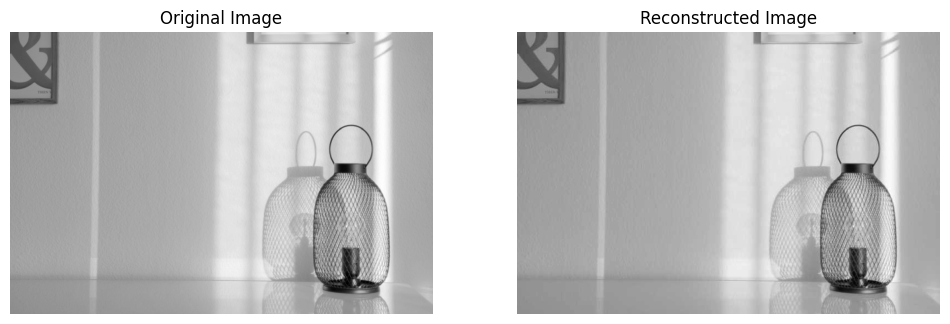

In [39]:
# Question 1

def image_encode(image, qtype='psyvisual', qf=1.0):
    """
    Encodes an input single channel image using block-based DCT, quantization,
    zigzag scanning, and Huffman coding.

    Args:
        image (np.ndarray): The input image.
        qtype (str, Default='psyvisual'): The quantization matrix type -
          'uniform', 'psyvisual' or 'chroma'.
        qf (float, Default=1.0): The quantization factor.
    Returns:
        A tuple containing:
            np.ndarray of the encoded image
            dict of the Huffman codebook
    """

    block_size = 8
    qmatrices = loadmat("code/quantization_matrices.mat")
    if qtype == 'uniform':
        qmatrix = qmatrices["uniform"].astype(float)
    elif qtype == 'psyvisual':
        qmatrix = qmatrices["psyvisual"].astype(float)
    elif qtype == 'chroma':
        qmatrix = qmatrices["chroma"].astype(float)

    # TODO: Perform DCT and quantization for each block using the 'block_process' function
    dct_quantize_handle = dct_quantize
    dct_image = block_process(image, (block_size,block_size) , dct_quantize_handle , qmatrix, qf)

    # Zigzag scan for each DCT block
    zigzag_handle = zigzag
    dct_coeffs = block_process(dct_image, (block_size, block_size), zigzag_handle)

    # Concatenate the zigzag-scanned blocks into a single vector
    dct_coeffs_matrix = np.hstack(np.vsplit(dct_coeffs, dct_coeffs.shape[0] // block_size**2))

    # Concatenate the non-zero elements of each column with a delimiter of 0.5.
    dct_coeffs_vector = np.array([])
    for column_index in range(dct_coeffs_matrix.shape[1]):
        # Remove trailing zeros from the column
        trimmed_column = np.trim_zeros(dct_coeffs_matrix[:, column_index], 'b')

        # TODO: Append the trimmed column to the end of vector, then append 0.5
        dct_coeffs_vector = np.concatenate( (dct_coeffs_vector,trimmed_column))
        dct_coeffs_vector = np.concatenate( (dct_coeffs_vector,[0.5]))
    # TODO: Huffman encode the DCT coefficients
    code, codebook = huffman_encode(dct_coeffs_vector)

    return code, codebook


def image_decode(code, codebook, image_shape, qtype='psyvisual', qf=1.0):
    """
    Decodes the given Huffman-encoded code and reconstructs the single channel image using
    inverse zigzag scanning, dequantization and block-based inverse DCT.

    Args:
        code (np.ndarray): The Huffman-encoded code.
        codebook (dict): The Huffman codebook used for encoding.
        image_shape (tuple): The shape of the original image.
        qtype (str, Default='psyvisual'): The quantization matrix type -
          'uniform', 'psyvisual' or 'chroma'.
        qf (float, Default=1.0): The quantization factor.

    Returns:
        np.ndarray of the reconstructed image.
    """
    block_size = 8

    # Decode the Huffman-encoded code
    decoded_vector = huffman_decode(code, codebook)

    # Initialize an empty matrix to store the DCT coefficients
    dct_coefficients = np.empty((block_size**2, image_shape[0] * image_shape[1] // (block_size**2)))

    index = 0
    block_index = 0
    for i in range(len(decoded_vector)):
        if decoded_vector[i] == np.pi:
            break
        if decoded_vector[i] != 0.5:
            continue

        current_coeffs = decoded_vector[index:i]
        current_coeffs_padded = np.pad(current_coeffs, (0,(block_size**2) - len(current_coeffs)), mode="constant", constant_values=0)
        dct_coefficients[:, block_index] = current_coeffs_padded.reshape(block_size**2)

        block_index += 1
        index = i + 1

    dct_coeffs_matrix  = np.vstack(np.hsplit(dct_coefficients, image_shape[0] // block_size))
    dct_image =  block_process(dct_coeffs_matrix, (block_size**2,1), izigzag, (block_size,block_size))

    # Load quantization matrix
    qmatrices = loadmat("code/quantization_matrices.mat")
    if qtype == 'uniform':
        qmatrix = qmatrices["uniform"].astype(float)
    elif qtype == 'psyvisual':
        qmatrix = qmatrices["psyvisual"].astype(float)
    elif qtype == 'chroma':
        qmatrix = qmatrices["chroma"].astype(float)

    # Perform deuqantization and inverse DCT for each block
    reconstructed_image = block_process(dct_image, (block_size,block_size), dequantize_idct, qmatrix, qf)
    reconstructed_image = np.clip(reconstructed_image, 0, 255)

    return reconstructed_image.astype(np.uint8)


# TODO: Check 'image_encode' by encdoing one of the images
#       and then decoding it using the 'image_decode' function

exp_image =exp_image1

our_code, our_codebook= image_encode(exp_image1)
reconstructed_exp_image = image_decode(our_code, our_codebook , exp_image.shape)

# Display original and reconstructed images
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(exp_image, cmap="gray")
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(reconstructed_exp_image, cmap="gray")
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()


In [40]:
help(np.concatenate)


Help on _ArrayFunctionDispatcher in module numpy:

concatenate(...)
    concatenate((a1, a2, ...), axis=0, out=None, dtype=None, casting="same_kind")
    
    Join a sequence of arrays along an existing axis.
    
    Parameters
    ----------
    a1, a2, ... : sequence of array_like
        The arrays must have the same shape, except in the dimension
        corresponding to `axis` (the first, by default).
    axis : int, optional
        The axis along which the arrays will be joined.  If axis is None,
        arrays are flattened before use.  Default is 0.
    out : ndarray, optional
        If provided, the destination to place the result. The shape must be
        correct, matching that of what concatenate would have returned if no
        out argument were specified.
    dtype : str or dtype
        If provided, the destination array will have this dtype. Cannot be
        provided together with `out`.
    
        .. versionadded:: 1.20.0
    
    casting : {'no', 'equiv', 'safe

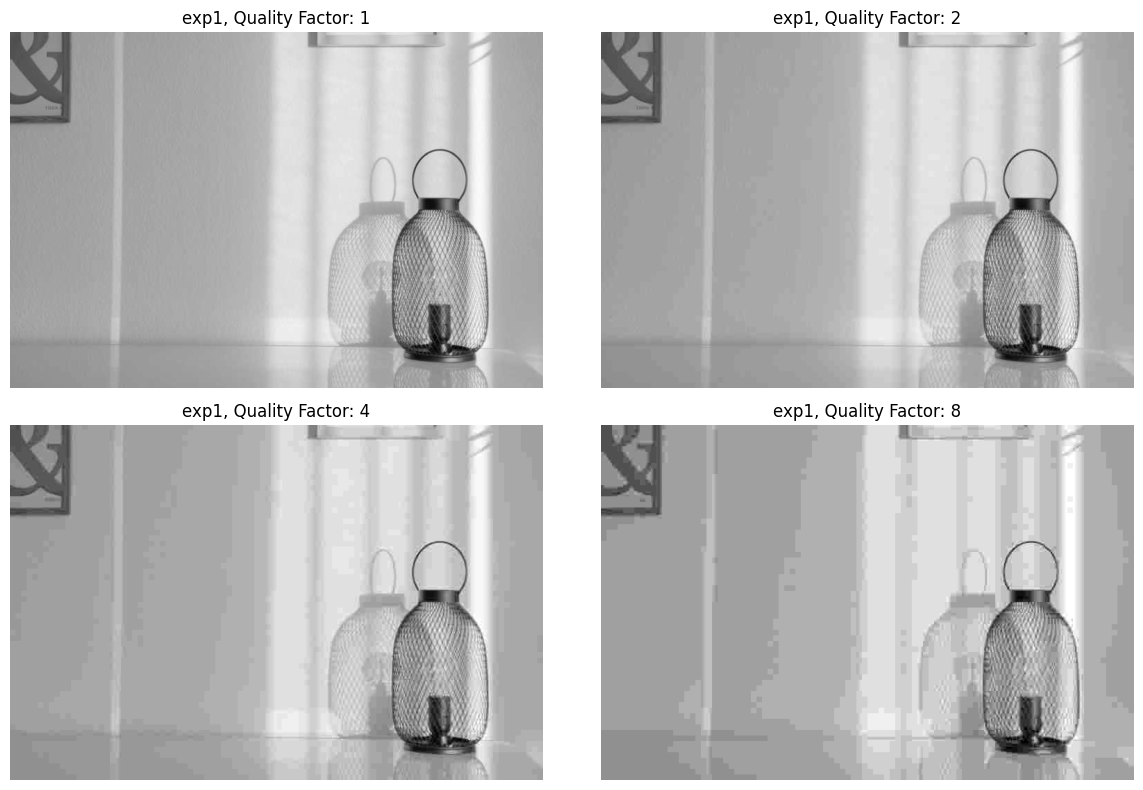

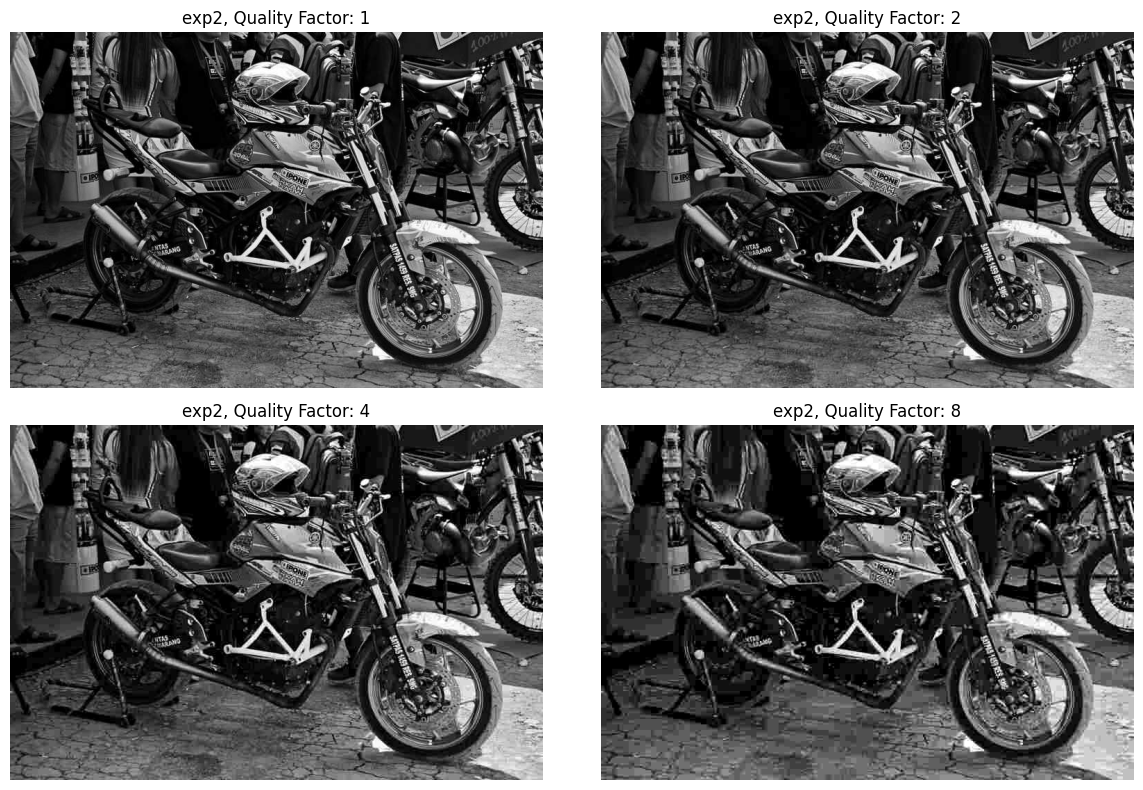

 the valuse of psnr_1 [38.266527648389015, 35.76199456259094, 33.25942028562113, 30.25170220584235]
 the valuse of psnr_2 [30.056467458097128, 27.54267861600387, 25.371935878142764, 23.14690148933357]
 the valuse of ssim_1 [0.9551319141241189, 0.9353618489370527, 0.9022940011807601, 0.8511349306746129]
 the valuse of ssim_2 [0.924911349708871, 0.8779422678971401, 0.8063888874274215, 0.6910927193238555]


In [44]:
# Question 2

quality_factors = [1, 2, 4, 8]
encoded_images1 = []
encoded_images2 = []
reconstructed_images1 = []
reconstructed_images2 = []
compression_ratios1 = []
compression_ratios2 = []
psnr_values1 = []
psnr_values2 = []
ssim_values1 = []
ssim_values2 = []

# TODO: Encode exp_image1 & exp_image2 using 'image_encode' with qf of 1, 2, 4, 8
#       Compute the compression ratio, PSNR and SSIM for the 8 images
for qf in quality_factors:
    code1, codebook1 = image_encode(exp_image1, qf = qf)
    encoded_images1.append (code1)
    code2, codebook2 = image_encode(exp_image2, qf = qf)
    encoded_images2.append (code2)
    
    decoded1 = image_decode(code1, codebook1, image_shape = exp_image1.shape, qf = qf)
    reconstructed_images1.append(decoded1)
    decoded2 = image_decode(code2, codebook2, image_shape = exp_image2.shape, qf = qf)
    reconstructed_images2.append(decoded2)
    
    psnr_values1.append (metrics.peak_signal_noise_ratio(exp_image1, decoded1))
    ssim_values1.append (metrics.structural_similarity(exp_image1, decoded1))
    
    psnr_values2.append(metrics.peak_signal_noise_ratio(exp_image2,decoded2))
    ssim_values2.append(metrics.structural_similarity(exp_image2, decoded2))
    
    compression_ratios1.append(compression_ratio(exp_image1, code1, codebook1))
    compression_ratios2.append(compression_ratio(exp_image2, code2, codebook2))



# Show the 8 reconstructed images
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed_images1[i], cmap='gray')
    ax.set_title(f'exp1, Quality Factor: {quality_factors[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed_images2[i], cmap='gray')
    ax.set_title(f'exp2, Quality Factor: {quality_factors[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

print(f" the valuse of psnr_1 {psnr_values1}")
print(f" the valuse of psnr_2 {psnr_values2}")
print(f" the valuse of ssim_1 {ssim_values1}")
print(f" the valuse of ssim_2 {ssim_values2}")


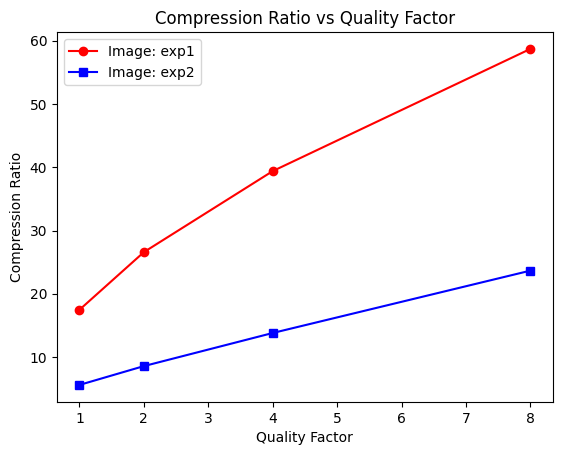

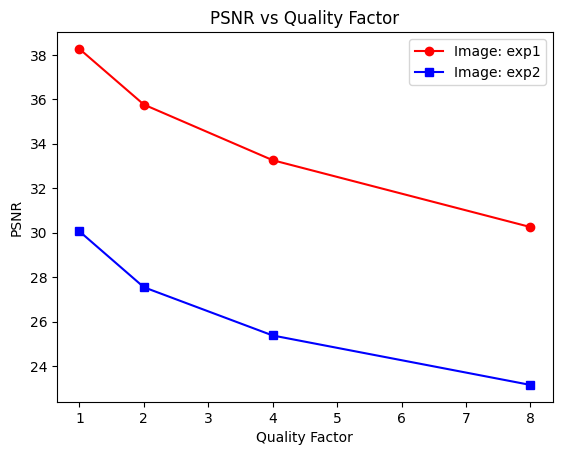

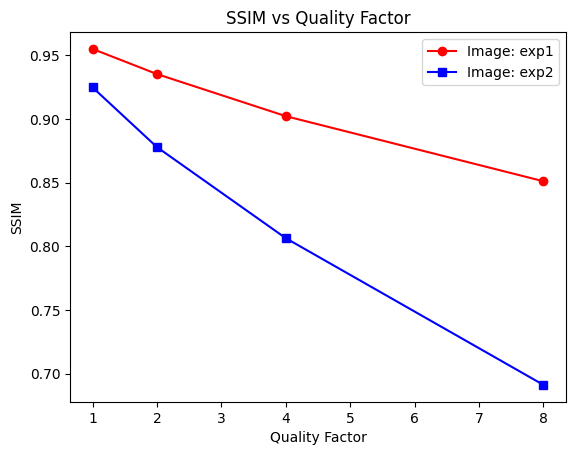

In [45]:
# Question 4

# Show compression ratio vs. qf
fig, ax = plt.subplots()
ax.plot(quality_factors, compression_ratios1, label='Image: exp1', marker='o', color='r')
ax.plot(quality_factors, compression_ratios2, label='Image: exp2', marker='s', color='b')
ax.set_xlabel('Quality Factor')
ax.set_ylabel('Compression Ratio')
ax.set_title('Compression Ratio vs Quality Factor')
ax.legend()
plt.show()

# Show PSNR vs. qf
fig, ax = plt.subplots()
ax.plot(quality_factors, psnr_values1, label='Image: exp1', marker='o', color='r')
ax.plot(quality_factors, psnr_values2, label='Image: exp2', marker='s', color='b')
ax.set_xlabel('Quality Factor')
ax.set_ylabel('PSNR')
ax.set_title('PSNR vs Quality Factor')
ax.legend()
plt.show()

# Show SSIM vs. qf
fig, ax = plt.subplots()
ax.plot(quality_factors, ssim_values1, label='Image: exp1', marker='o', color='r')
ax.plot(quality_factors, ssim_values2, label='Image: exp2', marker='s', color='b')
ax.set_xlabel('Quality Factor')
ax.set_ylabel('SSIM')
ax.set_title('SSIM vs Quality Factor')
ax.legend()
plt.show()


In [108]:
# Question 6
#exp_image1 = io.imread('images/0/exp1.png', as_gray=True)
# visual_prep, thermal_prep_uint8
naknik=visual_prep('images/naknik.jpeg')

# TODO: Encode a visual image you took in the first meeting and print the compression ratio
#       Don't forget to use the 'visual_prep' function
naknik = np.resize(naknik, (naknik.shape[0]-5, naknik.shape[1]))

naknik_encoded, codebookNeko = image_encode(naknik)
comp_ratioNeko = compression_ratio(naknik, naknik_encoded, codebookNeko)
print(f'Compression Ratio for visual image: {comp_ratioNeko: .2f}')



# TODO: Encode a thermal image of the same scene you took in the first meeting and print
#       the compression ratio. Don't forget to use the to 'thermal_prep_uint8' function
naknik_t = thermal_prep_uint8('images/nakniktherm.jpg')

naknik_encoded_t, codebookNekoT = image_encode(naknik_t)
comp_ratioNekoT = compression_ratio(naknik_t, naknik_encoded_t, codebookNekoT)
print(f'Compression Ratio for visual image: {comp_ratioNekoT: .2f}')

Compression Ratio for visual image:  10.67
Compression Ratio for visual image:  53.90


<class 'SyntaxError'>: invalid syntax (C:/Users/danelv/AppData/Local/Temp/xpython_10016/50664720.py, line 1)

# Assignment 4 - Color Image Compression


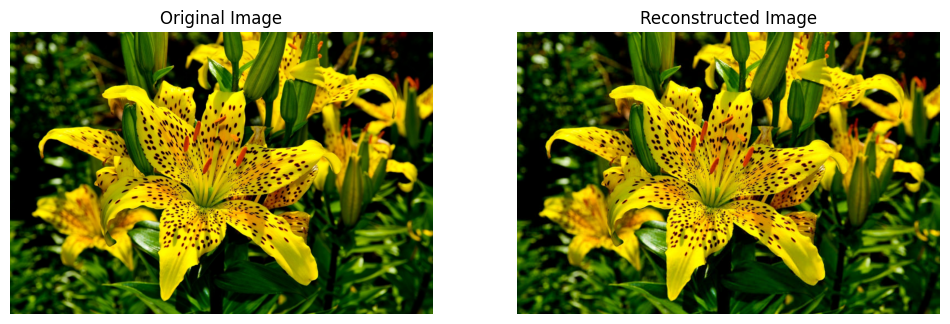

In [94]:
# Questions 1, 4, 5

def color_image_encode(image, qf=1.0, colorspace='RGB'):
    """
    Encodes an input 3-channel image using block-based DCT, quantization,
    zigzag scanning, and Huffman coding.

    Args:
        image (np.ndarray): The input image.
        qf (float, Default=1.0): The quantization factor.
        colorspace (str, Default='RGB'): The color space for encoding -
          'RGB', 'YCbCr444', or 'YCbCr420'.

    Returns:
        A tuple containing:
            np.ndarray of the encoded image.
            list of indices for separating the encoded data into channels.
            list of dicts that are Huffman codebooks, one for each channel.
    """

    qtype_channel0 = 'psyvisual'
    qtype_channel1 = 'psyvisual'
    qtype_channel2 = 'psyvisual'

    # TODO: In question 4, handle colorspace == 'YCbCr444'
    if colorspace in ['YCbCr444', 'YCbCr420']:
        qtype_channel1 = 'chroma'
        qtype_channel2 = 'chroma'
        image = color.rgb2ycbcr(image)
        
    # TODO: Separate the image to channels
    channel0 = image[:,:,0]
    channel1 = image[:,:,1]
    channel2 = image[:,:,2]

    # TODO: In question 5, handle also colorspace == 'YCbCr420'
    image_shape = image.shape
    
    if colorspace == 'YCbCr420':
        channel1_shape = (image_shape[0] // 2, image_shape[1] // 2)
        channel2_shape = (image_shape[0] // 2, image_shape[1] // 2)
        channel1 = transform.resize(channel1, channel1_shape, anti_aliasing=True)
        channel2 = transform.resize(channel2, channel2_shape, anti_aliasing=True)
        channel1 = channel1.astype(np.uint8)
        channel2 = channel2.astype(np.uint8)
    
    
    # TODO: Encode the three channels separately using the 'image_encode' function
    channel0_code, channel0_codebook = image_encode(channel0, qtype = qtype_channel0, qf=qf)
    channel1_code, channel1_codebook = image_encode(channel1, qtype = qtype_channel1, qf=qf)
    channel2_code, channel2_codebook = image_encode(channel2, qtype = qtype_channel2, qf=qf)

    # TODO: Concatenate the three channel codes
    code = channel0_code + channel1_code + channel2_code
    
    # TODO: Create a list of the three channel codebooks
    codebooks = [channel0_codebook,channel1_codebook,channel2_codebook]

    # Calculate the separation indices for the channels
    separation_indices = [len(channel0_code), len(channel0_code) + len(channel1_code)]

    return code, separation_indices, codebooks


def color_image_decode(code, separation_indices, codebooks, image_shape, qf=1.0, colorspace='RGB'):
    """
    Decodes the given Huffman-encoded code and reconstructs the 3-channel image using
    inverse zigzag scanning, dequantization and block-based inverse DCT.

    Args:
        code (np.ndarray): The Huffman-encoded code.
        separation_indices (list): Indices separating the three channels in the code.
        codebooks (list of dicts): The Huffman codebooks for decoding each channel.
        image_shape (tuple): The Shape of the original image.
        qf (float, Default=1.0): The quantization factor.
        colorspace (str, Default='RGB'): The color space for encoding -
          'RGB', 'YCbCr444', or 'YCbCr420'.

    Returns:
        np.ndarray of the reconstructed color image.
    """

    # Create an empty array to store the reconstructed image
    reconstructed_image = np.empty((image_shape[0], image_shape[1], 3))

    channel0_shape = image_shape
    channel1_shape = image_shape
    channel2_shape = image_shape

    qtype_channel0 = 'psyvisual'
    qtype_channel1 = 'psyvisual'
    qtype_channel2 = 'psyvisual'

    # For YCbCr chroma channels, use chroma quantization matrix
    if colorspace in ['YCbCr444', 'YCbCr420']:
        qtype_channel1 = 'chroma'
        qtype_channel2 = 'chroma'

        # For YCbCr420 colorspac, modify chroma channel shapes
        if colorspace == 'YCbCr420':
            channel1_shape = (image_shape[0] // 2, image_shape[1] // 2)
            channel2_shape = (image_shape[0] // 2, image_shape[1] // 2)

    # Decode the three channels
    reconstructed_channel0 = image_decode(code[:separation_indices[0]], codebooks[0], channel0_shape, qtype_channel0, qf)
    reconstructed_channel1 = image_decode(code[separation_indices[0]:separation_indices[1]], codebooks[1], channel1_shape, qtype_channel1, qf)
    reconstructed_channel2 = image_decode(code[separation_indices[1]:], codebooks[2], channel2_shape, qtype_channel2, qf)

    # For YCbCr420 colorspace, resize the chroma channels
    if colorspace == 'YCbCr420':
       reconstructed_channel1 = reconstructed_channel1.astype(np.float64)
       reconstructed_channel2 = reconstructed_channel2.astype(np.float64)
       reconstructed_channel1 = transform.resize(reconstructed_channel1, (reconstructed_channel1.shape[0] * 2,reconstructed_channel1.shape[1] * 2), anti_aliasing=True)
       reconstructed_channel2 = transform.resize(reconstructed_channel2, (reconstructed_channel2.shape[0] * 2,reconstructed_channel2.shape[1] * 2), anti_aliasing=True)
       reconstructed_channel1 = reconstructed_channel1.astype(np.uint8)
       reconstructed_channel2 = reconstructed_channel2.astype(np.uint8)

    # Assign the reconstructed channels to the respective channels in the output image
    reconstructed_image[:,:,0] = reconstructed_channel0
    reconstructed_image[:,:,1] = reconstructed_channel1
    reconstructed_image[:,:,2] = reconstructed_channel2

     # If YCbCr, convert to RGB
    if colorspace in ['YCbCr444', 'YCbCr420']:
        reconstructed_image = color.ycbcr2rgb(reconstructed_image)
        reconstructed_image = np.clip(reconstructed_image, 0, 1) # clip to remove negative values
        reconstructed_image = reconstructed_image * 255

    return reconstructed_image.astype(np.uint8)


# TODO: Check the 'color_image_encode' function by encdoing one of the images
#       expc1 or expc2 and then decoding it using the 'color_image_decode' function
expc_image = io.imread('images/9/expc1.png')
uno, dos, tres=color_image_encode(expc_image)
reconstructed_expc_image = color_image_decode(uno, dos, tres,expc_image.shape)

# Show the original and reconstructed images
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(expc_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(reconstructed_expc_image)
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()


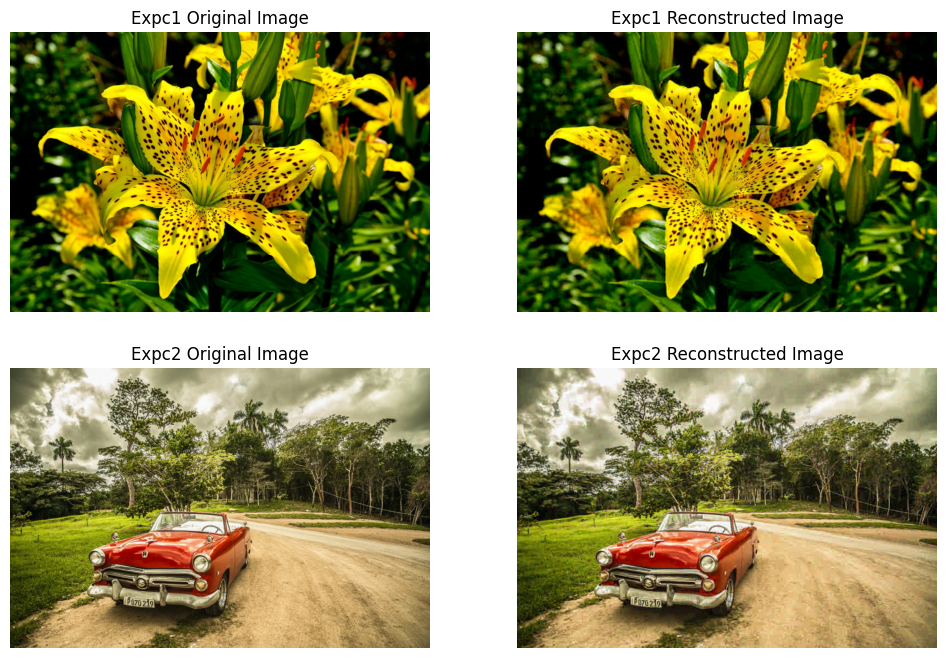

Compression Ratio of Expc1: 23.15
Compression Ratio of Expc2: 15.39
PSNR of Expc1: 30.14
PSNR of Expc2: 24.84
SSIM of Expc1: 0.831
SSIM of Expc2: 0.758


In [95]:
# Question 2

def color_compression_ratio(image, code, codebooks):
    """
    Computes the compression ratio of a color image.

    Args:
        image (np.ndarray): The original uncompressed image.
        code (str): The encoded image.
        codebook (list of dicts): A list of three codebooks used for encoding.

    Returns:
        float of the compression ratio of the image.
    """

    # TODO: Calculate the image size in bits
    image_size = image.size*8

    # TODO: Calculate the code size in bits
    code_size = len(code)*8

    # Calculate the the total codebook size in bits
    total_codebook_size = 0
    for codebook in codebooks:
        codebook_keys_size = sum(8 for _ in codebook)
        codebook_values_size = sum(len(c) for c in codebook.values())
        codebook_size = codebook_keys_size + codebook_values_size
        total_codebook_size += codebook_size

    encoded_size = code_size + total_codebook_size

    return image_size / encoded_size


# TODO: Encode expc1 and expc2 with 'qf=4.0'  return code, separation_indices, codebooks
expc_image1 = io.imread('images/9/expc1.png')
expc_image1_code, expc_separation_indices1, expc_image1_codebooks = color_image_encode(expc_image1, qf=4)
reconstructed_expc_image1 = color_image_decode(expc_image1_code, expc_separation_indices1, expc_image1_codebooks, expc_image1.shape, qf=4)

expc_image2 = io.imread('images/9/expc2.png')
expc_image2_code, expc_separation_indices2, expc_image2_codebooks = color_image_encode(expc_image2, qf=4)
reconstructed_expc_image2 = color_image_decode(expc_image2_code, expc_separation_indices2, expc_image2_codebooks, expc_image2.shape, qf=4)
    
# TODO: Show the two reconstructed images
    # Show the original and reconstructed images
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(expc_image1)
plt.title("Expc1 Original Image")
plt.axis('off')
    
plt.subplot(2,2,2)
plt.imshow(reconstructed_expc_image1)
plt.title("Expc1 Reconstructed Image")
plt.axis('off')


plt.subplot(2,2,3)
plt.imshow(expc_image2)
plt.title("Expc2 Original Image")
plt.axis('off')
    
plt.subplot(2,2,4)
plt.imshow(reconstructed_expc_image2)
plt.title("Expc2 Reconstructed Image")
plt.axis('off')
plt.show()
# TODO: Print compression ratio for the two compressed images

expc1_comp_ratio = color_compression_ratio(expc_image1, expc_image1_code, expc_image1_codebooks)
expc2_comp_ratio = color_compression_ratio(expc_image2, expc_image2_code, expc_image2_codebooks)

print(f'Compression Ratio of Expc1: {expc1_comp_ratio:.2f}')
print(f'Compression Ratio of Expc2: {expc2_comp_ratio:.2f}')

# TODO: Print SSIM and PSNR for the the two recnstructed images
#       When computing SSIM for a color image, use 'channel_axis=-1'

expc1_psnr = metrics.peak_signal_noise_ratio(expc_image1, reconstructed_expc_image1)
expc1_ssim = metrics.structural_similarity(expc_image1, reconstructed_expc_image1, channel_axis=-1)

expc2_psnr = metrics.peak_signal_noise_ratio(expc_image2, reconstructed_expc_image2)
expc2_ssim = metrics.structural_similarity(expc_image2, reconstructed_expc_image2, channel_axis=-1)

print(f'PSNR of Expc1: {expc1_psnr:.2f}')
print(f'PSNR of Expc2: {expc2_psnr:.2f}')

print(f'SSIM of Expc1: {expc1_ssim:.3f}')
print(f'SSIM of Expc2: {expc2_ssim:.3f}')
#       When computing SSIM for a color image, use 'channel_axis=-1'


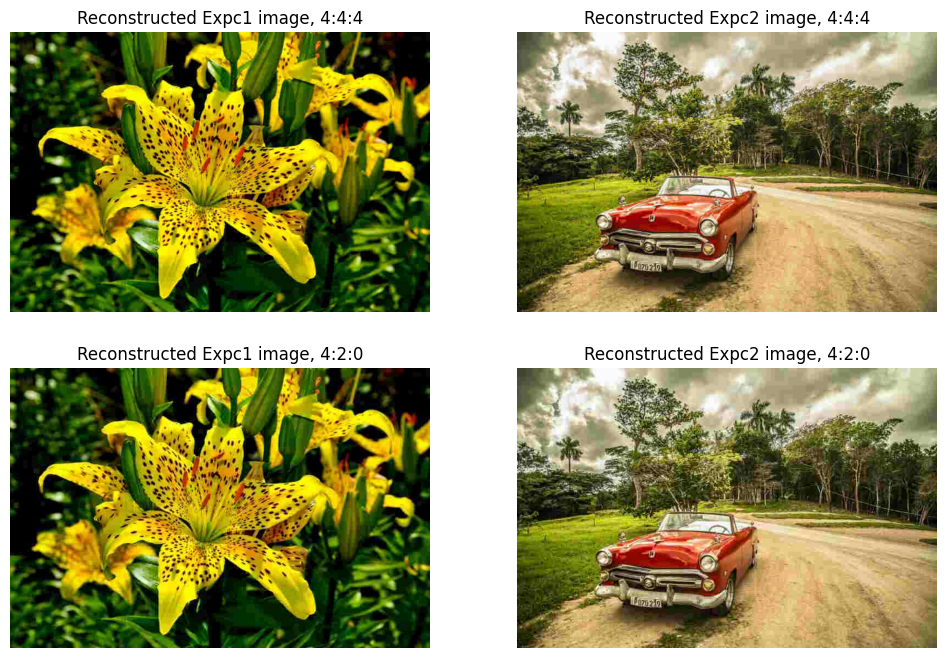

PSNR of Expc1 444: 26.75
PSNR of Expc2 444: 23.84
PSNR of Expc1 420: 25.46
PSNR of Expc2 420: 23.65
SSIM of Expc1 444: 0.707
SSIM of Expc2 444: 0.714
SSIM of Expc1 420: 0.691
SSIM of Expc2 420: 0.713


In [96]:
# Question 6

# TODO: Repeat question 2 in the YCbCr colorspace in 4:4:4 format

image1_code_444, separation_indices1_444, image1_codebooks_444 = color_image_encode(expc_image1, qf=4, colorspace = 'YCbCr444')
reconstructed_image1_444 = color_image_decode(image1_code_444, separation_indices1_444, image1_codebooks_444, expc_image1.shape, qf=4, colorspace = 'YCbCr444')

image2_code_444, separation_indices2_444, image2_codebooks_444 = color_image_encode(expc_image2, qf=4, colorspace = 'YCbCr444')
reconstructed_image2_444 = color_image_decode(image2_code_444, separation_indices2_444, image2_codebooks_444, expc_image2.shape,qf=4, colorspace = 'YCbCr444')

# TODO: Repeat question 2 in the YCbCr colorspace in 4:2:0 format
image1_code_420, separation_indices1_420, image1_codebooks_420 = color_image_encode(expc_image1, qf=4, colorspace = 'YCbCr420')
reconstructed_image1_420 = color_image_decode(image1_code_420, separation_indices1_420, image1_codebooks_420, expc_image1.shape,qf=4, colorspace = 'YCbCr420')

image2_code_420, separation_indices2_420, image2_codebooks_420 = color_image_encode(expc_image2, qf=4, colorspace = 'YCbCr420')
reconstructed_image2_420 = color_image_decode(image2_code_420, separation_indices2_420, image2_codebooks_420, expc_image2.shape,qf=4, colorspace = 'YCbCr420')



plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(reconstructed_image1_444)
plt.title("Reconstructed Expc1 image, 4:4:4")
plt.axis('off')
    
plt.subplot(2,2,2)
plt.imshow(reconstructed_image2_444)
plt.title("Reconstructed Expc2 image, 4:4:4")
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(reconstructed_image1_420)
plt.title("Reconstructed Expc1 image, 4:2:0")
plt.axis('off')
    
plt.subplot(2,2,4)
plt.imshow(reconstructed_image2_420)
plt.title("Reconstructed Expc2 image, 4:2:0")
plt.axis('off')
plt.show()
expc1_psnr_444 = metrics.peak_signal_noise_ratio(expc_image1, reconstructed_image1_444)
expc1_ssim_444 = metrics.structural_similarity(expc_image1, reconstructed_image1_444, channel_axis=-1)
expc2_psnr_444 = metrics.peak_signal_noise_ratio(expc_image2, reconstructed_image2_444)
expc2_ssim_444 = metrics.structural_similarity(expc_image2, reconstructed_image2_444, channel_axis=-1)

expc1_psnr_420 = metrics.peak_signal_noise_ratio(expc_image1, reconstructed_image1_420)
expc1_ssim_420 = metrics.structural_similarity(expc_image1, reconstructed_image1_420, channel_axis=-1)
expc2_psnr_420 = metrics.peak_signal_noise_ratio(expc_image2, reconstructed_image2_420)
expc2_ssim_420 = metrics.structural_similarity(expc_image2, reconstructed_image2_420, channel_axis=-1)

print(f'PSNR of Expc1 444: {expc1_psnr_444:.2f}')
print(f'PSNR of Expc2 444: {expc2_psnr_444:.2f}')

print(f'PSNR of Expc1 420: {expc1_psnr_420:.2f}')
print(f'PSNR of Expc2 420: {expc2_psnr_420:.2f}')

print(f'SSIM of Expc1 444: {expc1_ssim_444:.3f}')
print(f'SSIM of Expc2 444: {expc2_ssim_444:.3f}')

print(f'SSIM of Expc1 420: {expc1_ssim_420:.3f}')
print(f'SSIM of Expc2 420: {expc2_ssim_420:.3f}')

In [104]:
# Question 9

# TODO: Show two visual images you took
#       Don't forget to use the 'visual_prep' function with the parameter
#       'convert_to_grayscale=False'

mini_naknik= visual_prep('images/mini_naknik.jpeg',convert_to_grayscale=False)
airpods= visual_prep('images/airpods.jpeg', convert_to_grayscale=False)
mini_naknik = np.resize(mini_naknik, (mini_naknik.shape[0]-4, mini_naknik.shape[1],mini_naknik.shape[2]))
airpods = np.resize(airpods, (airpods.shape[0]-4, airpods.shape[1],airpods.shape[2]))

# TODO Encode the two images using the 'color_image_encode' function
mini_naknik_code, mini_naknik_separation, mini_naknik_codebook = color_image_encode(mini_naknik, qf=1)
airpods_code, airpods_separation, airpods_codebook = color_image_encode(airpods, qf=1)

# TODO Compute the two compression ratios using the 'color_compression_ratio'
#      function and print them
mini_naknik_comp_ratio = color_compression_ratio(mini_naknik, mini_naknik_code, mini_naknik_codebook)
airpods_comp_ratio = color_compression_ratio(airpods, airpods_code, airpods_codebook)

print(f'Compression Ratio of mini_naknik: {mini_naknik_comp_ratio:.2f}')
print(f'Compression Ratio of airpods: {airpods_comp_ratio:.2f}')


Compression Ratio of mini_naknik: 21.78
Compression Ratio of airpods: 17.65


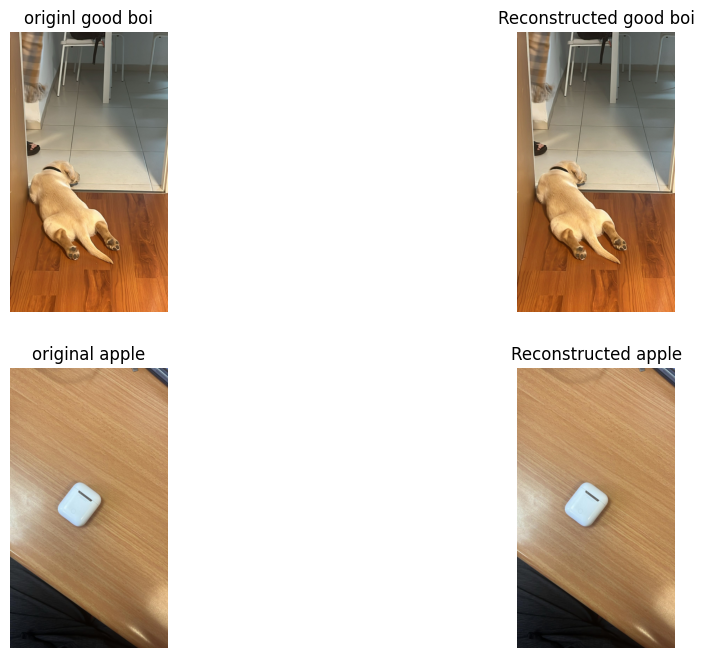

In [107]:
decomini= color_image_decode(mini_naknik_code, mini_naknik_separation, mini_naknik_codebook, mini_naknik.shape,qf=1)

decoairpods= color_image_decode(airpods_code, airpods_separation, airpods_codebook, airpods.shape,qf=1)


plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(mini_naknik)
plt.title("originl good boi")
plt.axis('off')
    
plt.subplot(2,2,2)
plt.imshow(decomini)
plt.title("Reconstructed good boi")
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(airpods)
plt.title("original apple")
plt.axis('off')
    
plt.subplot(2,2,4)
plt.imshow(decoairpods)
plt.title("Reconstructed apple")
plt.axis('off')
plt.show()

